# NBA_analysis
This would be NBA analysis based on data collected from kaggle containing 2012-2018 box scores for each player of each nba team.

Prepared by: __Karol Kaufman__  
GitHub: __TurboTiger-DS__  

Goal - to check how (un)predictable is the game of basketball in NBA. If the data can be fit, so the model predicts the outcome of games at higher level, can we beat the bookies.

Quick recap of data:
- Imported from kaggle. 
    - URL: https://www.kaggle.com/pablote/nba-enhanced-stats
    - Author: Paul Rossotti
- The data itself was separated by players. I had stats of each player during each NBA game
- My target was to prepare database to reflect statistical difference of teams and the result of those teams paying against each other. The idea here is to measure the differences of teams which are "entering" the particular game. Basing on those differences in ranking, player statistics, expert ratings we can try modeling the prediction of game's outcome.
- After multiple iterations, column renaming and merging of tables, we end up with data just as planned. 
- Data clearing has been performed separately in  _KAJMANOSYS_WORKBOOK.ipynb_


In [790]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [808]:
'''The table is an outcome of KAJMANOSYS_WORKBOOK. Contains 2012-2018 games data.'''
tbsall = pd.read_csv('C:\\Users\\Karol\\Desktop\\datareminder\\nba\\kaggle_stats\\tbsall_st_fin.csv')

### Variables
Variables that we may choose from:

 - Differences between averages of teams playing the game in categories such as: (Points, Assists, TurnOvers, Steals, Blocks and so on:
**'avgPTS', 'avgAST', 'avgTO', 'avgSTL', 'avgBLK', 'avgPF', 'avgFGA', 'avgFGM', 'avg2PA', 'avg2PM', 'avg3PA', 'avg3PM','avgFTA', 'avgFTM', 'avgORB', 'avgDRB'**
 
 - Differences between variances in each categories in the teams playing the game in categories such as: (Points, Assists, TurnOvers, Steals, Blocks and so on:
**'varPTS', 'varAST', 'varTO', 'varSTL', 'varBLK', 'varPF', 'varFGA', 'varFGM', 'var2PA', 'var2PM','var3PA', 'var3PM', 'varFTA', 'varFTM', 'varORB', 'varDRB'**

 *It was an experiment which did not work - the information in those variables created more chaos in models than i expected - nice learning experience however. The idea behind it was: is it important that on team is diversified between many players, or the teams with actual "stars" perform the best. So if the variance is higher in points, it should mean that we have some elite players in the team and some really bad players, and when variance is low it means that most of the players in the team perform on the same level*
 
 

 - Other game informations as teams conferences, current ranking, win/loss at home and away index, the number of days since last game for the team and so on:
**'awayAbbr','gmDate', 'opptAbbr', 'teamConf', 'teamDayOff', 'opptConf', 'opptDayOff', 'teamLoc', 'teamAbbr', 'teamConfInt','opptConfInt', 'rankDiff', 'stkDiff', 'gameBackDiff', 'ptsAllowDiff','winHADiff'**

In [813]:
'''Selecting the variables after feature selection process. Corr analysis, PCA etc.'''
target  = ['teamRslt']
#data_columns = ['avgPTS','avgAST','avgTO','avgSTL','avgBLK','avgPF','avgFGA','avgFGM','avg2PA','avg2PM','avg3PA','avg3PM','avgFTA','avgFTM','avgORB','avgDRB','teamDayOff', 'opptDayOff', 'teamConfInt', 'opptConfInt']
data_columns = ['avgDRB','avgSTL','avgBLK','avgPTS','avgAST','avgFGA','avg3PA',
                'avgFTA' ,'avgORB','teamDayOff', 'opptDayOff','rankDiff', 
                'gameBackDiff', 'ptsAllowDiff', 'winHADiff']

tbsall['teamConf'] = tbsall['teamConf'].map({'West': 1, 'East': 0})
tbsall['opptConf'] = tbsall['opptConf'].map({'West': 1, 'East': 0})


In [815]:
'''After many tries of modeling the whole dataset i came to the conclusion 
that data in the first 10 games of the season (for each team)is not sufficient.
Therefore it creates a lot of noise in our models.
I'll remove the samples from the beginning of each season and change our goal
to try to model the game outcome if the game occured after first part of the season.
All in all - we are removing around 10-15% of games in the beginning of the season
so the model does not try to predict the unpredictable.'''


tbs_filtered = tbsall[:0][:]
years = [2012, 2013, 2014, 2015, 2016, 2017, 2018]
for year in years:
    tbs_filtered = tbs_filtered.append(tbsall[tbsall['season']==year][300:][:])

In [765]:
#Separating to features(X) and target(y)
X, y = tbs_filtered[:][data_columns].values, tbs_filtered[:][target].values

In [816]:
'''
On of the goals is to predict games in current season. I'm splitting the data so the 2018 season is our test samples.
Later on we'll also perform KFold analysis to measure accuracy (and then we separate the data without looking at the season)

We could use train_test_split so keeping it commented if we have to:
'''
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

X_train, y_train = tbs_filtered[tbs_filtered['season']<2018][data_columns].values, tbs_filtered[tbs_filtered['season']<2018][target].values
X_test, y_test = tbs_filtered[tbs_filtered['season']==2018][data_columns].values, tbs_filtered[tbs_filtered['season']==2018][target].values

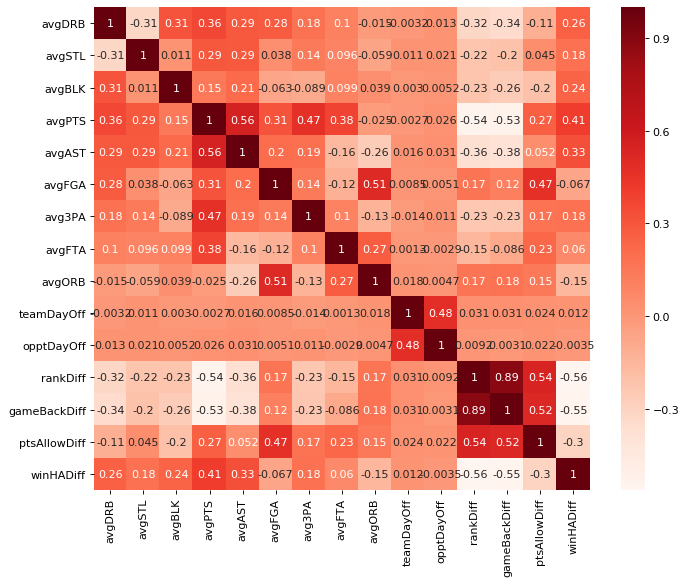

In [818]:
'''Visualizing correlation matrix of the selected variables'''

import seaborn as sns
%matplotlib inline
cor = tbs_filtered[data_columns].corr()
plt.figure(figsize=(10,8),dpi= 80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
bottom, top = ax.get_ylim()
#Bug in pyplot. First and last row fixing:
ax.set_ylim(bottom + 0.5, top - 0.5)
#pyplot.savefig('corrmx.png')
plt.show()

In [832]:
'''Normalizing the data'''

from sklearn.preprocessing import Normalizer

scaler = Normalizer().fit(X_train)
normalized_X = scaler.transform(X_train)
normalized_X_test = scaler.transform(X_test)
X_train = normalized_X
X_test = normalized_X_test


0.2574024070141287


In [823]:
'''Encoding target variable to 0's and 1's '''

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_ytr = encoder.transform(y_train)
encoded_yte = encoder.transform(y_test)
y_train = encoded_ytr
y_test = encoded_yte

In [877]:
'''Trying out the activation functions, number of hidden layers as well as number of nodes which can work the best for us'''

from keras.utils import to_categorical 
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import adam
from keras.callbacks import EarlyStopping
from keras.utils import plot_model


n_variables = X_train.shape[1]
target_train = to_categorical(y_train)
target_test = to_categorical(y_test)


model = Sequential()
model.add(Dense(14, activation='relu', input_shape=(n_variables,)))
model.add(Dense(14, activation='relu', input_shape=(14,)))
model.add(Dense(1, activation='sigmoid'))

#for now taking those arbitrarly:
opt = SGD(lr=0.1, momentum=0.5)
#es = EarlyStopping(monitor='val_accuracy', patience=30)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']) 

In [878]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=0)

In [879]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print(history.history.keys())

Train: 0.710, Test: 0.698
dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


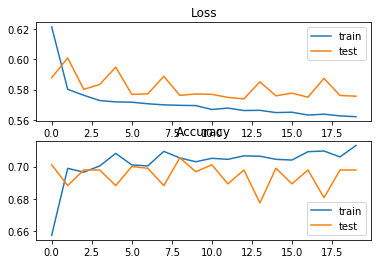

In [880]:

from matplotlib import pyplot
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

#pyplot.savefig('lessvarsplot.png')
pyplot.show()



In [609]:
#model.save('model_standingsvars_1.h5')

In [885]:
'''As the previous results are not really great, ill try to fine-tune some parameters.
Hopefully the accuracy can be improved by couple of percent.
Here checking which learning rate/momentum combo is working best.
As the dataset is not really huge, we can train the model couple of times to see what performs the best.'''

lr_lst = [0.001, 0.01, 0.05, 0.1, 0.2]
mom_lst = [0, 0.1, 0.3, 0.5, 0.9]

def create_model(lr_i, mom_i):
    model = Sequential()
    model.add(Dense(20, activation='relu', input_shape=(n_variables,)))
    model.add(Dense(10, activation='relu', input_shape=(20,)))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(lr=lr_i, momentum=mom_i)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']) 
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=0)
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('Train: %.3f, Test: %.3f, Parameters: LR= %.3f MOMENTUM=%.3f' % (train_acc, test_acc, lr_i, mom_i))

In [886]:
for learningrate in lr_lst:
    for momentum in mom_lst:
        create_model(learningrate,momentum)

Train: 0.592, Test: 0.581, Parameters: LR= 0.001 MOMENTUM=0.000
Train: 0.583, Test: 0.581, Parameters: LR= 0.001 MOMENTUM=0.100
Train: 0.595, Test: 0.586, Parameters: LR= 0.001 MOMENTUM=0.300
Train: 0.592, Test: 0.582, Parameters: LR= 0.001 MOMENTUM=0.500
Train: 0.686, Test: 0.695, Parameters: LR= 0.001 MOMENTUM=0.900
Train: 0.692, Test: 0.699, Parameters: LR= 0.010 MOMENTUM=0.000
Train: 0.596, Test: 0.582, Parameters: LR= 0.010 MOMENTUM=0.100
Train: 0.698, Test: 0.694, Parameters: LR= 0.010 MOMENTUM=0.300
Train: 0.695, Test: 0.692, Parameters: LR= 0.010 MOMENTUM=0.500
Train: 0.710, Test: 0.698, Parameters: LR= 0.010 MOMENTUM=0.900
Train: 0.704, Test: 0.699, Parameters: LR= 0.050 MOMENTUM=0.000
Train: 0.705, Test: 0.698, Parameters: LR= 0.050 MOMENTUM=0.100
Train: 0.704, Test: 0.698, Parameters: LR= 0.050 MOMENTUM=0.300
Train: 0.701, Test: 0.692, Parameters: LR= 0.050 MOMENTUM=0.500
Train: 0.715, Test: 0.697, Parameters: LR= 0.050 MOMENTUM=0.900
Train: 0.705, Test: 0.695, Parameters: L

In [893]:
'''Further more we can see whether the intialization of weights and biases can help us improve the score.
We are taking LR=0.1 and momentum=0.5 as per previous analysis'''


initializers = ['zeros', 'random_normal','glorot_normal', 'he_uniform', 'ones']

def create_model_initializers(initializer, lr_i=0.1, mom_i=0.5):
    model = Sequential()
    model.add(Dense(20, activation='relu', input_shape=(n_variables,), kernel_initializer=initializer))
    model.add(Dense(10, activation='relu', input_shape=(20,), kernel_initializer=initializer))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(lr=lr_i, momentum=mom_i)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']) 
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, verbose=0)
    _, train_acc = model.evaluate(X_train, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print('Train: %.3f, Test: %.3f, Parameters: LR=%.3f momentum=%.3f initializer=%s' % (train_acc, test_acc, lr_i, mom_i, initializer ))
    
for initializer in initializers:
        create_model_initializers(initializer=initializer)

Train: 0.592, Test: 0.582, Parameters: LR=0.100 momentum=0.500 initializer=zeros
Train: 0.695, Test: 0.689, Parameters: LR=0.100 momentum=0.500 initializer=random_normal
Train: 0.708, Test: 0.690, Parameters: LR=0.100 momentum=0.500 initializer=glorot_normal
Train: 0.700, Test: 0.701, Parameters: LR=0.100 momentum=0.500 initializer=he_uniform
Train: 0.589, Test: 0.576, Parameters: LR=0.100 momentum=0.500 initializer=ones


In [956]:
'''As it seems we squeezed as much information as we could from this data 
let's perform stratified KFold to confirm the accuracy that we come up with with the parameters of our choosing:'''
from sklearn.model_selection import StratifiedKFold
seed = 28 #my basketball jersey number :)
np.random.seed(seed)

X_k, y_k = tbs_filtered[:][data_columns].values, tbs_filtered[:][target].values.ravel()

scaler = StandardScaler().fit(X_k)
standarized_Xk = scaler.transform(X_k)
X_k = standarized_Xk

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_k)
encoded_yk = encoder.transform(y_k)
y_k = encoded_yk


cvscores = []
def create_model_kfold():
    for train, test in kfold.split(X_k, y_k.ravel()):
        model = Sequential()
        model.add(Dense(20, activation='tanh', input_shape=(n_variables,), kernel_initializer='he_uniform'))
        model.add(Dense(15, activation='tanh', input_shape=(20,), kernel_initializer='he_uniform'))
        model.add(Dense(1, activation='sigmoid'))
        opt = SGD(lr=0.01, momentum=0.5)
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']) 
        model.fit(X_k[train], y_k[train], epochs=20, batch_size=10, verbose=0)
        scores = model.evaluate(X_k[test], y_k[test], verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
    print("Mean accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
        

In [957]:
create_model_kfold()

accuracy: 67.08%
accuracy: 71.91%
accuracy: 69.23%
accuracy: 70.48%
accuracy: 70.43%
accuracy: 70.92%
accuracy: 74.33%
accuracy: 69.12%
accuracy: 69.30%
accuracy: 71.10%
Mean accuracy: 70.39% (+/- 1.84%)


## Quick conclusion
The project was a fun experience. Most of the time was spent on data preprocessing as i needed to merge couple of different datasources, and completely redo the tables to come from player-notation to team-notation.

The models have not been a great success when it comes to accuracy. I assume this might because one of 3 reasons:
 - Data Sparcity - all in all, my models had only ~20 statistically important variables and ~6k observations. Not great not terrible
 - Randomness of the sport itself - expecting to predict over 90% of the games would be silly as the sport seems to be much more unpredictable.
 - Simplyfying the models. The next steps (which i'll still try to perform are to gather more data and variables, and try some merging of the models. XGBoost if applicable will be my next step for that.
 
 It seems as deep neural networks have been not great improvement over the simple models. Logistic regression (the best of the baseline models) has achieved 64% of the accuracy on the given data.
 So we are looking at 4-6% predictability accuracy improvement with deep neural network. (2 hidden layers). More layers contributed only to overfitting data.
 